In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import urllib
from bs4 import BeautifulSoup

In [3]:
def get_data():
    source=urllib.request.urlopen('https://www.exchangerates.org.uk/GBP-USD-exchange-rate-history.html')
    html=source.read()
    
    soup = BeautifulSoup(html,"lxml")
    #(soup.prettify())
    soup.a
    
    data_table=soup.find('table',{"id":'hist'})
    #print (data_table)
    
    day=[]
    rate=[]
    
    for counter,row in enumerate(data_table.findAll('tr')):
        cells=row.findAll('td')
        if len(cells)==3:
            day.append(((cells[0].find(text=True)).split(None,1))[1])
            rate.append(float(((cells[1].find(text=True)).split(' '))[3]))
            
    date=[]
    for counter,object_ in enumerate(day):
        date.append(pd.datetime.strptime(object_, "%d %B %Y"))
        
    rate_data=pd.DataFrame({'Day':date,'Rate':rate})
    rate_data=rate_data.set_index('Day')
    rate_data_full=rate_data.reindex(index=rate_data.index[::-1])
    
    return rate_data_full

In [4]:
rate_data = get_data()

In [6]:
type(rate_data), type(rate_data.Rate)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [9]:
rate_data.columns

Index(['Rate'], dtype='object')

In [6]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error as MSE


In [21]:
# plt.rcParams['figure.figsize']
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10

In [8]:
rate_data.index

DatetimeIndex(['2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11',
               ...
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31'],
              dtype='datetime64[ns]', name='Day', length=180, freq=None)

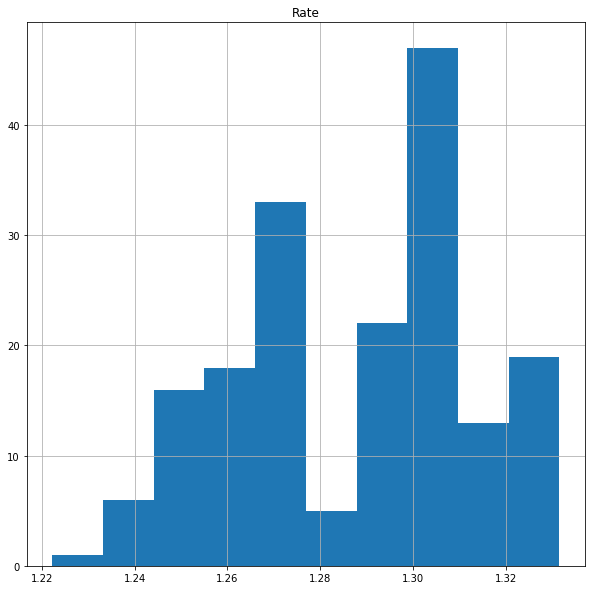

In [23]:
rate_data.hist()
plt.show()

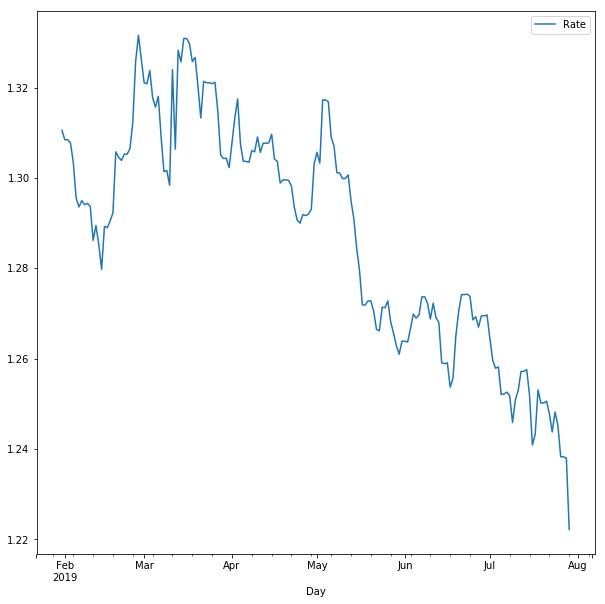

In [24]:
rate_data.plot()
plt.show()

In [25]:
df_test = adfuller(rate_data['Rate'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)


Test Statistic                  -0.380320
p-value                          0.913333
#Lags Used                       2.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64


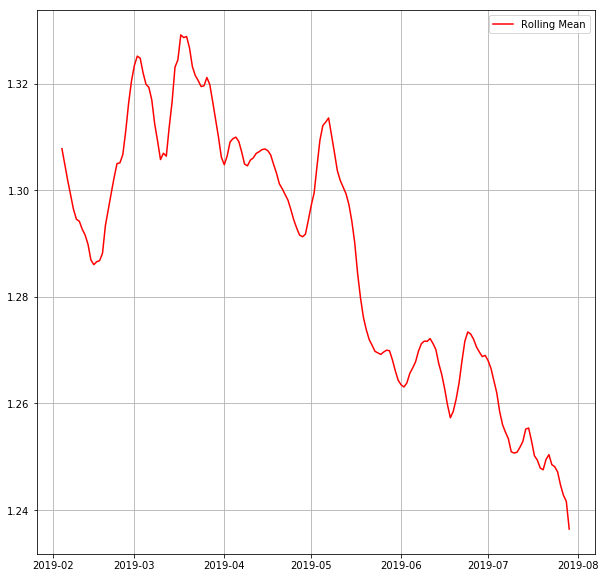

In [28]:
rolling_mean = pd.Series.rolling(rate_data['Rate'],window=5,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
#rate_data.plot()
rmean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.grid()
plt.show()



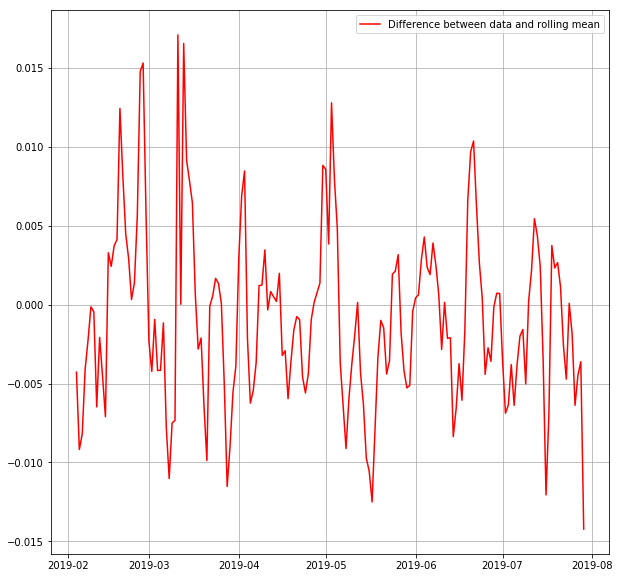

In [29]:
rolling_mean_diff=rate_data['Rate']-rolling_mean
#plt.rcParams["figure.figsize"] = fig_size
plt.plot(rolling_mean_diff, color='red',label='Difference between data and rolling mean')
plt.legend(loc='best')
plt.grid()
plt.show()
rolling_mean_diff.dropna(inplace=True)

In [34]:
rolling_mean_diff

Day
2019-02-04   -0.00428
2019-02-05   -0.00918
2019-02-06   -0.00820
2019-02-07   -0.00410
2019-02-08   -0.00226
2019-02-09   -0.00014
2019-02-10   -0.00046
2019-02-11   -0.00648
2019-02-12   -0.00208
2019-02-13   -0.00452
2019-02-14   -0.00710
2019-02-15    0.00328
2019-02-16    0.00242
2019-02-17    0.00372
2019-02-18    0.00412
2019-02-19    0.01242
2019-02-20    0.00816
2019-02-21    0.00448
2019-02-22    0.00292
2019-02-23    0.00032
2019-02-24    0.00138
2019-02-25    0.00564
2019-02-26    0.01476
2019-02-27    0.01530
2019-02-28    0.00580
2019-03-01   -0.00232
2019-03-02   -0.00424
2019-03-03   -0.00094
2019-03-04   -0.00418
2019-03-05   -0.00416
               ...   
2019-06-30    0.00070
2019-07-01   -0.00354
2019-07-02   -0.00688
2019-07-03   -0.00636
2019-07-04   -0.00380
2019-07-05   -0.00638
2019-07-06   -0.00382
2019-07-07   -0.00200
2019-07-08   -0.00158
2019-07-09   -0.00502
2019-07-10    0.00022
2019-07-11    0.00216
2019-07-12    0.00544
2019-07-13    0.00436
2019-0

In [35]:
df_test = adfuller(rolling_mean_diff, autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                -6.581549e+00
p-value                        7.492374e-09
#Lags Used                     2.000000e+00
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64
